In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
from easydict import EasyDict
import yaml
from sklearn.model_selection import train_test_split
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder  
import librosa
import librosa.display
import cv2

import IPython.display as ipd

import tensorflow_datasets as tfds

# Loading dataset

In [ ]:
ds = tfds.load('vctk', 
               split='train', 
               shuffle_files=True, 
               data_dir='/content/drive/MyDrive/НИС_2022/accent_recognition')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [11]:
%cd /content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data

/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data


In [13]:
!touch config.yaml

In [2]:
speaker_info_path = '/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data/speaker-info.txt'
speakers_dict = {}
speakers = []
labels = []
with open(speaker_info_path) as f:
    line = f.readline()
    while line:
        line = f.readline()
        try:
          accent = line.split()[3]
          speaker = line.split()[0]
          if accent == 'Unknown' or accent == 'British' or accent == 'NewZealand' or accent == 'Welsh':
              continue
          if accent in speakers_dict:
              speakers_dict[accent] += 1
          else:
              speakers_dict[accent] = 1
          speakers.append(speaker)
          labels.append(accent)
        except:
          continue

In [3]:
speakers_dict

{'American': 22,
 'Australian': 2,
 'Canadian': 8,
 'English': 33,
 'Indian': 3,
 'Irish': 9,
 'NorthernIrish': 6,
 'Scottish': 19,
 'SouthAfrican': 4}

In [4]:
speakers_train, speakers_test, labels_train, labels_test = train_test_split(
     speakers,  labels, test_size=0.2, random_state=42)

In [47]:
with open('/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data/config.yaml') as conf:
    cfg = EasyDict(yaml.safe_load(conf))

print(cfg)

{'clip_length': 5.0, 'sample_rate': 44100, 'hop_length': 441, 'n_fft': 1024, 'n_mels': 64, 'f_min': 0, 'f_max': 22050}


In [5]:
len(labels_test)

22

In [5]:
path = '/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data/wav48_silence_trimmed/'
speakers_train_paths = []
speakers_train_labels = []
count = 0
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 50:
      files = files[:50]
    for file_name in files:
        speakers_train_paths.append(speaker_path + file_name)
        speakers_train_labels.append(label)


In [6]:
speakers_test_paths = []
speakers_test_labels = []
count = 0
for speaker, label in zip(speakers_test, labels_test):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 50:
      files = files[:50]
    for file_name in files:
        speakers_test_paths.append(speaker_path + file_name)
        speakers_test_labels.append(label)

In [7]:
speaker_set = set(speakers_train_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{'NorthernIrish', 'American', 'Canadian', 'Australian', 'Indian', 'English', 'Scottish', 'Irish'}


In [8]:
speaker_set = set(speakers_test_labels)
number_of_unique_values = len(speaker_set)
print(speaker_set)

{'NorthernIrish', 'American', 'English', 'Scottish', 'Irish'}


In [9]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

# Data sample

In [10]:
path = '/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data/wav48_silence_trimmed/p225/p225_002_mic2.flac'

In [11]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:],rate=sample_rate)

In [13]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled



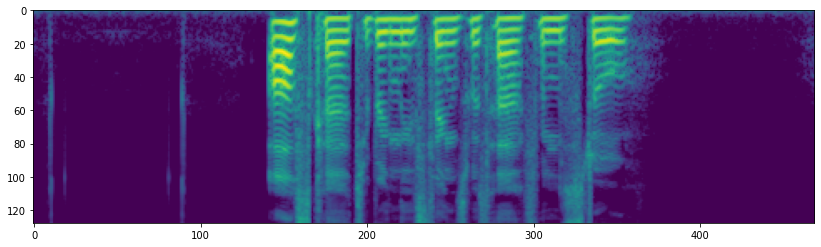

In [30]:
melspectrogram = spec_to_image(get_melspectrogram_db(path))

plt.figure(figsize=(14, 8))
plt.imshow(melspectrogram)

In [17]:
res = cv2.resize(melspectrogram, dsize=(128, 64), interpolation=cv2.INTER_CUBIC)

In [31]:
melspectrogram.shape

(128, 469)

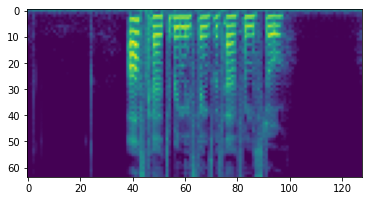

In [18]:
plt.imshow(res)

In [34]:
np.reshape(res, (1, 64, 128)).shape

(1, 64, 128)

# Format data

In [28]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    # spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        mel_specgram = spec_to_image(get_melspectrogram_db(filename))[np.newaxis,...]
        res = cv2.resize(mel_specgram[0, :, :], dsize=(128, 64), interpolation=cv2.INTER_CUBIC)
        return torch.tensor(np.reshape(res, (1, 64, 128)), dtype = torch.float), self.labels[index]

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

torch.Size([1, 64, 128])


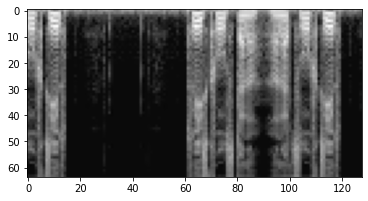

In [29]:
def display_img(img,label):
    print(img.shape)
    plt.imshow(img[0, :, :], cmap='gray')

display_img(*train_dataset[1])

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

# Define the Network

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [34]:
class AccentClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(32768, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 8)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [36]:
model = AccentClassification()
model = model.to(device)

In [37]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

Epoch [0], train_loss: 3.9632, val_loss: 1.8187, val_acc: 0.2182
Epoch [1], train_loss: 1.6980, val_loss: 1.9319, val_acc: 0.2014
Epoch [2], train_loss: 1.6414, val_loss: 4.1868, val_acc: 0.2998
Epoch [3], train_loss: 1.6648, val_loss: 2.2433, val_acc: 0.2205
Epoch [4], train_loss: 1.5325, val_loss: 2.1852, val_acc: 0.2291


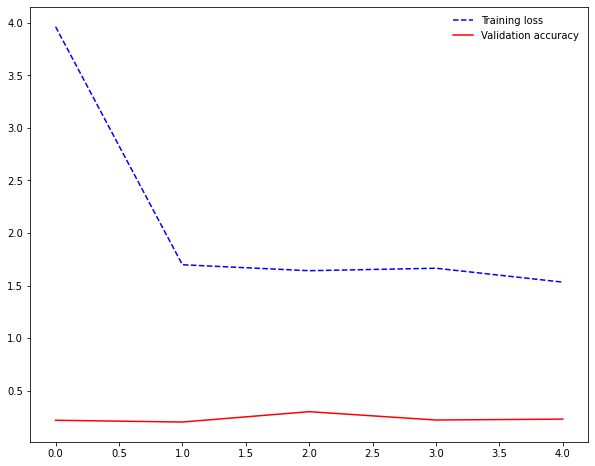

In [38]:
fig = plt.figure(figsize=(10, 8))
plt.plot([x["train_loss"] for x in history], 'b--', label='Training loss')
plt.plot([x["val_acc"] for x in history], 'r', label='Validation accuracy')
# plt.plot([x["val_loss"] for x in history], 'b', label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = model(images)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append([x[1] for x in y_pred_tag.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [43]:
confusion_matrix(y_labels_list, y_pred_list)

array([[50, 25,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0],
       [51, 24,  0,  0,  0,  0],
       [16,  9,  0,  0,  0,  0],
       [11, 14,  0,  0,  0,  0],
       [25, 25,  0,  0,  0,  0]])

In [40]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.33      0.67      0.44        75
         1.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00        75
         5.0       0.00      0.00      0.00        25
         6.0       0.00      0.00      0.00        25
         7.0       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.05      0.11      0.07       250
weighted avg       0.10      0.20      0.13       250



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [42]:
le.classes_

array(['American', 'Australian', 'Canadian', 'English', 'Indian', 'Irish',
       'NorthernIrish', 'Scottish'], dtype='<U13')

# Espnet fine-tuning